In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from time import time
from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from gds.demo.data.data_methods import get_casualties_dataset, reduce_weather_categories

In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [8]:
accidents_data = get_casualties_dataset()
accidents_data.dropna(inplace=True)
data = accidents_data.copy()

fields = {
    "reference": "string",
    "casualty_severity": "category",
    "weather": "category",
    "ward_name": "category",
    "date": "string",
}
data = data[fields.keys()]
data = data.astype(fields)
data = data.set_index("reference")

data["datetime"] = pd.to_datetime(data.date, format="%Y-%m-%dT%H:%M:%S")
data["hour"] = pd.DatetimeIndex(data.datetime).hour
data["hour"] = data["hour"].astype("category")
data["day"] = pd.DatetimeIndex(data.datetime).strftime("%A")
data["day"] = data["day"].astype("category")

data.drop(["date", "datetime"], axis=1, inplace=True)

data.weather = data.weather.map(reduce_weather_categories)

data.head()

,casualty_severity,weather,ward_name,hour,day
reference,,,,,
0105EO41028,3 Slight,1 Fine,Cantelowes,11,Thursday
0105EO00017,3 Slight,1 Fine,Camden Town with Primrose Hill,9,Friday
0105EO41319,3 Slight,1 Fine,Cantelowes,9,Tuesday
0105EO40989,3 Slight,1 Fine,Holborn and Covent Garden,14,Tuesday
0105EO40492,3 Slight,1 Fine,Cantelowes,22,Sunday


In [10]:
def group_severity(row):
    if row["casualty_severity"] in ["1 Fatal", "2 Serious"]:
        return 1
    else:
        return 0

In [12]:
def data_two_category_all_data(data):
    data["casualty_severity"] = data.apply(lambda x: group_severity(x), axis=1)
    severity_raw = data["casualty_severity"]
    features_raw = data.drop("casualty_severity", axis=1)
    data_manip_identifer = "two_category_all_data"
    return severity_raw, features_raw, data_manip_identifer

def data_two_category_balanced_data(data):
    data["casualty_severity"] = data.apply(lambda x: group_severity(x), axis=1)

    df_fatal = data[data.casualty_severity == 1].copy()
    n_fatal = df_fatal.shape[0]
    df_slight = data[data.casualty_severity == 0].sample(n=n_fatal)
    data = pd.concat([df_slight, df_fatal])
    data = data.sample(frac=1)

    severity_raw = data["casualty_severity"]
    features_raw = data.drop("casualty_severity", axis=1)
    data_manip_identifer = "two_category_balanced_data"
    return severity_raw, features_raw, data_manip_identifer

In [13]:
severity_raw, features_raw, data_manip_identifer = data_two_category_balanced_data(data)

In [14]:
print(pd.get_dummies(features_raw))
print(pd.get_dummies(features_raw).keys())
print(features_raw.ward_name.unique())
print(len(pd.get_dummies(features_raw).keys()))

print(severity_raw.value_counts())
filted_data = pd.get_dummies(features_raw).astype(np.float64)
print(f"Number of features in the model {filted_data.shape[1]}")


             weather_1 Fine  weather_2 Raining  weather_3 Snowing  \
reference                                                           
0111CW10455               1                  0                  0   
0113EK40456               1                  0                  0   
1170073274                1                  0                  0   
1170080418                1                  0                  0   
1170076157                0                  0                  0   
...                     ...                ...                ...   
0109TB00060               1                  0                  0   
1160022478                1                  0                  0   
0108CW12129               1                  0                  0   
0116EK40087               0                  1                  0   
0114EO40532               1                  0                  0   

             weather_7 Fog/Mist  weather_8 Other  weather_9 Unknown  \
reference                      

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
filted_data, severity_raw, test_size=0.2, random_state=0,
)
X_train.head()

,weather_1 Fine,weather_2 Raining,weather_3 Snowing,weather_7 Fog/Mist,weather_8 Other,weather_9 Unknown,ward_name_Belsize,ward_name_Bloomsbury,ward_name_Camden Town with Primrose Hill,ward_name_Cantelowes,...,hour_21,hour_22,hour_23,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
reference,,,,,,,,,,,,,,,,,,,,,
1170061040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0113EK40829,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0108CW12129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1160006218,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0110CW11020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
def train_predict(learner, X_train, y_train, X_test, y_test):
    """
    train learner on training data and pull out some important metrics
    """
    results = {}

    start = time()  # Get start time
    learner = learner.fit(X_train, y_train)
    end = time()  # Get end time

    results["train_time"] = end - start

    start = time()  # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()  # Get end time

    results["pred_time"] = end - start
    results["acc_train"] = accuracy_score(y_train, predictions_train)
    results["acc_test"] = accuracy_score(y_test, predictions_test)
    results["f_train"] = fbeta_score(
        y_train, predictions_train, beta=0.5, average="micro"
    )
    results["f_test"] = fbeta_score(y_test, predictions_test, beta=0.5, average="micro")

    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_test)))

    return results


In [23]:
clf_A = DecisionTreeClassifier(random_state=9)
clf_B = AdaBoostClassifier(random_state=9)
clf_C = GradientBoostingClassifier(random_state=9)
clf_D = RandomForestClassifier(random_state=9)

results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    clf_name = clf_name.replace("Classifier", "")
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)
pprint(results)

DecisionTreeClassifier trained on 524 samples.
AdaBoostClassifier trained on 524 samples.
GradientBoostingClassifier trained on 524 samples.
RandomForestClassifier trained on 524 samples.
{'AdaBoost': {'acc_test': 0.49809160305343514,
              'acc_train': 0.563992359121299,
              'f_test': 0.49809160305343514,
              'f_train': 0.563992359121299,
              'pred_time': 0.03439927101135254,
              'train_time': 0.1099700927734375},
 'DecisionTree': {'acc_test': 0.5038167938931297,
                  'acc_train': 0.8529130850047756,
                  'f_test': 0.5038167938931297,
                  'f_train': 0.8529130850047756,
                  'pred_time': 0.006773710250854492,
                  'train_time': 0.025600194931030273},
 'GradientBoosting': {'acc_test': 0.517175572519084,
                      'acc_train': 0.6418338108882522,
                      'f_test': 0.517175572519084,
                      'f_train': 0.6418338108882522,
               

In [38]:
def evaluate(results):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    subplot_titles = (
        "train_time",
        "acc_train",
        "f_train",
        "pred_time",
        "acc_test",
        "f_test",
    )
    # fig = tools.make_subplots(rows=2, cols=3, subplot_titles=subplot_titles)
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
    ax = [item for sublist in ax for item in sublist]

    result_df = pd.DataFrame.from_dict(results)
    x = result_df.index.to_list()

    for j, metric in enumerate(
        ["train_time", "acc_train", "f_train", "pred_time", "acc_test", "f_test"]
    ):
        result_df.T[metric].plot.bar(x=result_df.T[metric].index, y=metric, ax=ax[j])
        ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=45, ha="right")
        ax[j].set_title(metric)
        if j not in [0, 3]:
            ax[j].set_ylim(0, 1.0)
            # ax[j].plot([-1.0, 4.5], [0.33, 0.33], "k--")
            ax[j].plot([-1.0, 4.5], [0.5, 0.5], "k--")

    fig.tight_layout()

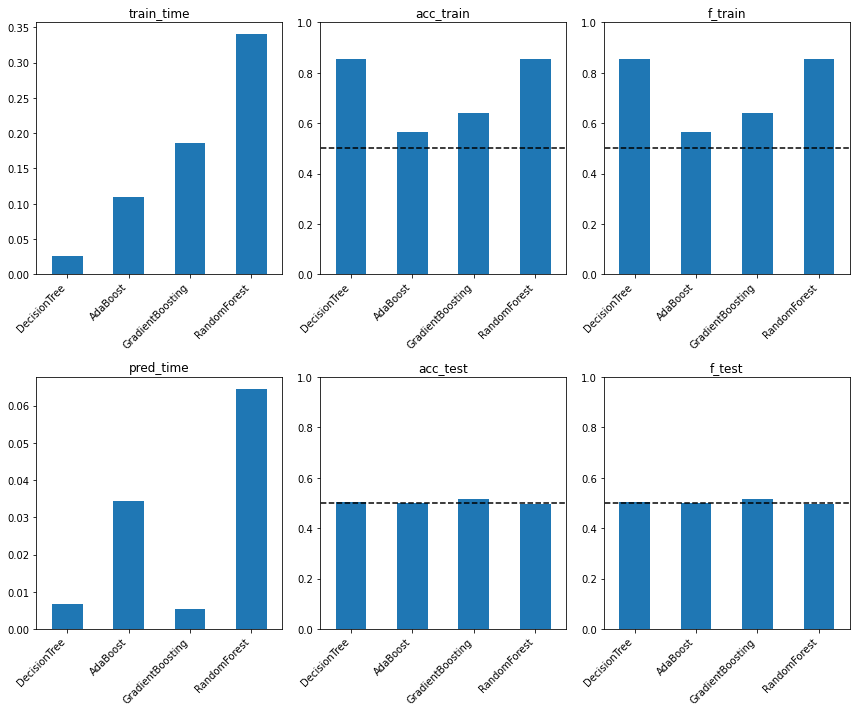

In [39]:
evaluate(results)

In [44]:
def feature_plot(importances, X_train):
    fig, ax = plt.subplots(figsize=(10,8))

    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:20]]
    values = importances[indices][:20]
    cumulative_weight = np.cumsum(values)

    ax.bar(columns, values)
    ax.scatter(columns, cumulative_weight)

    ax.set_xticklabels(columns, rotation=45, ha="right")

    fig.tight_layout()


/home/billy/.virtualenvs/GDS/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


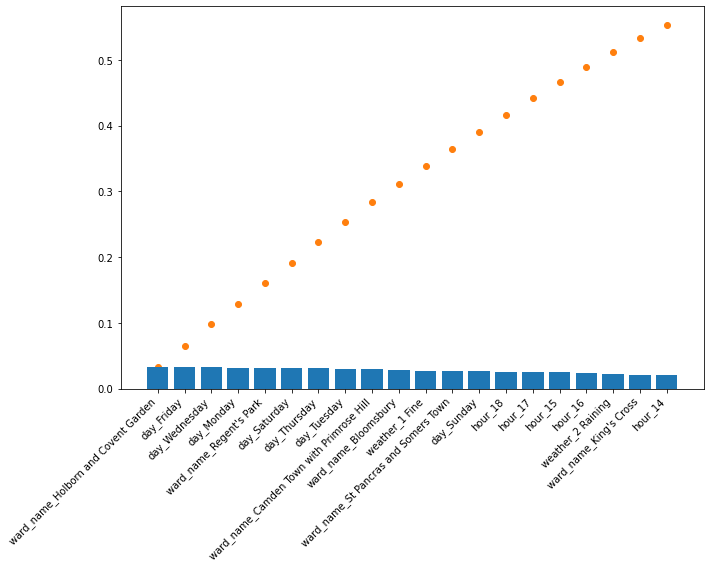

In [45]:
best_clf = clf_D
feature_plot(best_clf.feature_importances_, X_train)

### conclusion